# 데이터 불러오기

In [1]:
import pandas as pd

# 사용자가 영화(->종목 카테고리별 프로그램과 매칭한 정보)를 평가한 점수에 대한 테이블
# 각 사용자가 여러 개가 아닌 한 개의 선호도만 입력했다고 가정
rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 영화의 제목(->프로그램명)과 장르(->종목)에 대한 테이블
# 만약 사용자가 여러번 선호도 조사를 했다면
# 맨 앞 컬럼에 사용자 id 넣어 구분해줄 필요가 있음)
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# EDA

In [3]:
print("고유 아이디 수:", len(rating_df["user_id"].unique()))
print("영화의 개수:", len(rating_df["movie_id"].unique()))

고유 아이디 수: 6040
영화의 개수: 3706


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

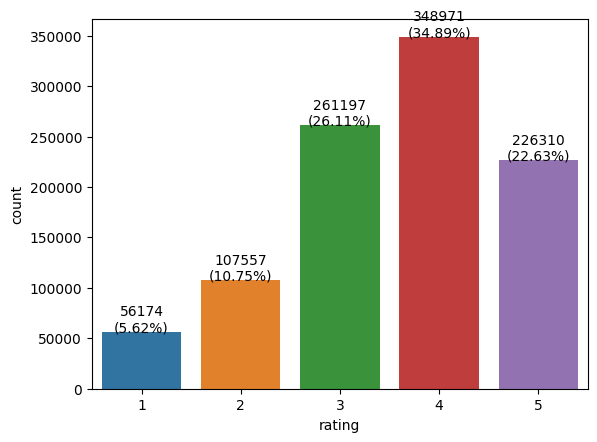

In [5]:
# 평점 순서 지정 (오름차순)
rating_order = sorted(rating_df["rating"].unique())

# Seaborn countplot에 order 매개변수 추가
sns.countplot(x=rating_df["rating"], order=rating_order)

# 그래프 꾸미기
object_cnt = rating_df["rating"].value_counts()
for x, y, z in zip(object_cnt.index, object_cnt.values, object_cnt.values / object_cnt.sum() * 100):
    plt.annotate(f"{y}\n({round(z, 2)}%)", xy=(x - 1, y + 70), textcoords="data", ha="center")

plt.show()

# Matrix Factorization Modeling

## MF-based (SVD) 모델 학습

In [6]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163489 sha256=cd6980636e808703e738b001592f701a1071bc11c833eaefc7de14e9cf7a22b9
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [7]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import time
from surprise import accuracy

# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리


reader = Reader(rating_scale=(1,5)) 	#1~5점 사이의 rating점수가 있다는 것을 알려줌
data = Dataset.load_from_df(rating_df[["user_id", "movie_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.25)


param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []

# n_factor depth에 따른 RMSE 확인
for n in param_list:
   train_start = time.time()
   algo = SVD(n_factors=n)
   algo.fit(trainset)
   train_end = time.time()
   print("training time of model: %.2f seconds" % (train_end-train_start))
   print(f"RMSE of test dataset in SVD model, n_factors={n}")

   # 모델 평가
   predictions = algo.test(testset)
   rmse_list_by_factors.append(accuracy.mse(predictions))
   ttime_list_by_factors.append(train_end-train_start)
   print("-"*20)

print("searching n_factors is finish.")

training time of model: 25.77 seconds
RMSE of test dataset in SVD model, n_factors=10
MSE: 0.7729
--------------------
training time of model: 17.09 seconds
RMSE of test dataset in SVD model, n_factors=50
MSE: 0.7646
--------------------
training time of model: 19.82 seconds
RMSE of test dataset in SVD model, n_factors=100
MSE: 0.7719
--------------------
training time of model: 25.83 seconds
RMSE of test dataset in SVD model, n_factors=150
MSE: 0.7779
--------------------
training time of model: 31.06 seconds
RMSE of test dataset in SVD model, n_factors=200
MSE: 0.7815
--------------------
searching n_factors is finish.


## n_factor에 따른 RMSE 시각화

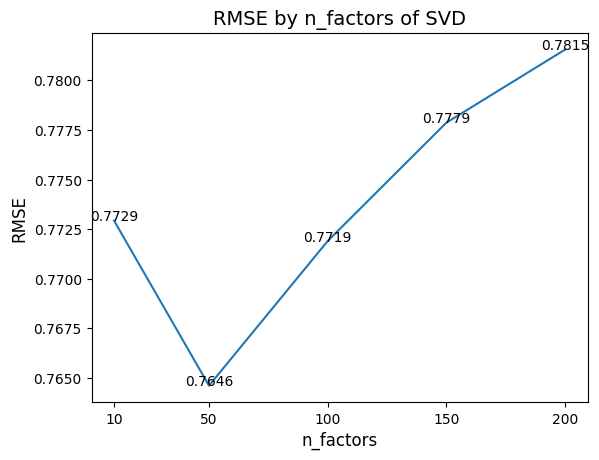

In [8]:
import matplotlib.pyplot as plt

# plt의 plot 함수로 결과 시각화
plt.plot(param_list, rmse_list_by_factors)
plt.title("RMSE by n_factors of SVD", fontsize=14)
plt.xticks(param_list)
plt.xlabel("n_factors", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

for x, y in zip(param_list, rmse_list_by_factors):
    plt.annotate(f'{round(y, 4)}', xy=(x, y), textcoords="data", ha="center")

plt.show()

## 최종 RMSE 평가

In [9]:
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
acc = accuracy.rmse(predictions)
acc

RMSE: 0.8757


0.8756985362115447

## 시간을 고려해서 SVD 모델 학습

In [10]:
rating_df['time'].quantile(q=0.8, interpolation='nearest') # 8:2로 나눌 수 있는 시간 기준탐색 --> 975768738

train_df = rating_df[rating_df["time"]< 975768738][["user_id", "movie_id", "rating"]]
test_df = rating_df[rating_df["time"]>= 975768738][["user_id", "movie_id", "rating"]]

# 추출한 학습 데이터셋으로 SVD 모델 학습
data = Dataset.load_from_df(train_df, reader=reader)
train_data = data.build_full_trainset()

algo = SVD(n_factors=50)
algo.fit(train_data)

## 테스트 및 평가

In [11]:
# 예측할 부분 (rating이 없는) 데이터만 추출
test_data = train_data.build_anti_testset()


predictions = algo.test(test_data)

# test 평가를 위해 시청하지 않은 영화의 예상 점수를 dictionary 형태로 추출
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

# K파라미터 별 추천 결과 평가 및 시각화

In [26]:
# 사용자 정보를 담고 있는 DataFrame
user_watch_dict_list_test = pd.DataFrame({
    'user_id': test_df["user_id"],  # test_df rating_df
    'watched_movies': test_df["movie_id"]
})


def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]

      # user_watch_dict_list_test가 DataFrame이고, index에 user가 존재하는지 확인
      if isinstance(user_watch_dict_list_test, pd.DataFrame) and user in user_watch_dict_list_test.index:
          actual_watch_list = user_watch_dict_list_test.loc[user].values.tolist()

          # 예측 값의 길이가 0인 경우 처리
          if len(top_k_prefer_list) == 0:
              continue

          # top_k_prefer_list의 길이가 k보다 작은 경우 처리
          if len(top_k_prefer_list) < k:
              remaining_movies = set(movie[0] for movie in estimated_list[k:]) - set(top_k_prefer_list)
              top_k_prefer_list.extend(list(remaining_movies)[:k - len(top_k_prefer_list)])

          user_metric.append((user, top_k_prefer_list, actual_watch_list))
      else:
          print(f"사용자 {user}에 대한 데이터가 올바르게 로드되지 않았습니다.")
    except Exception as e:
      print(f"사용자 {user}에 대한 오류: {str(e)}")
      # 필요한 대로 오류 처리

  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    if len(predictive_values) > 0:
        precision = len(tp) / len(predictive_values)
        precision_list.append(precision)

  if len(precision_list) > 0:
      return sum(precision_list) / len(precision_list)
  else:
      return 0


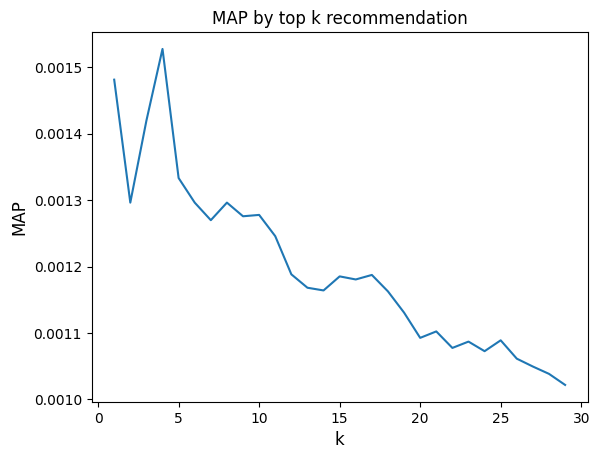

In [27]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:
  map_list.append(get_map_topk(k))

plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')# 대부분 추천시스템의 MAP는 0.1~0.2 사이
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

# Example!